DATA PREPROCESSING

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

df_total = pd.DataFrame()

#ENTER YOUR USERNAME 

user = ''

# Define the folder containing the CSV files
data_path_2 = f'/Users/{user}/Downloads/UVAmacro-main/post_1/data/dataset2'

# folder containing exported figures 
figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_1/figures'


# dataset 2


df_OIS_rates = pd.read_csv(f'{data_path_2}/OIS_swap_rates.csv')
df_move_level = pd.read_csv(f'{data_path_2}/move_level.csv')
df_2yr_yield = pd.read_csv(f'{data_path_2}/2yr_yield.csv')
df_10yr_yield = pd.read_csv(f'{data_path_2}/10yr_yield.csv')
df_20yr_yield = pd.read_csv(f'{data_path_2}/20yr_yield.csv')
df_30yr_yield = pd.read_csv(f'{data_path_2}/30yr_yield.csv')
df_tp = pd.read_csv(f'{data_path_2}/ACM.csv')
df_2yr_yield = pd.read_csv(f'{data_path_2}/2yr_yield.csv')
df_5yr_yield = pd.read_csv(f'{data_path_2}/5yr_yield.csv')


df_OIS_rates.rename(columns={'observation_date': 'Date'}, inplace=True)
df_OIS_rates['Date'] = pd.to_datetime(df_OIS_rates['Date'])


df_tp['Date'] = pd.to_datetime(df_tp['Date'])
df_tp = df_tp[['Date', 'ACMTP10']]
df_tp = df_tp.rename(columns={'ACMTP10': '10y_tp'})

df_move_level['Date'] = pd.to_datetime(df_move_level['Date'])
df_move_level = df_move_level[['Date', 'Price']]
df_move_level = df_move_level.rename(columns={'Price': 'move_level'})


df_10yr_yield['Date'] = pd.to_datetime(df_10yr_yield['Date'])
df_20yr_yield['Date'] = pd.to_datetime(df_20yr_yield['Date'])
df_30yr_yield['Date'] = pd.to_datetime(df_30yr_yield['Date'])
df_2yr_yield['Date'] = pd.to_datetime(df_2yr_yield['Date'])
df_5yr_yield['Date'] = pd.to_datetime(df_5yr_yield['Date'])


df_total_2 = df_move_level
dfs = [
    df_10yr_yield, df_20yr_yield, df_30yr_yield, df_tp, df_2yr_yield, df_5yr_yield, df_OIS_rates]

for df in dfs:
    df_total_2 = df_total_2.merge(df, on='Date', how='inner')


df_total_2['butterfly_swap'] = (df_total_2['5yr_OIS_swap'] - (df_total_2['2yr_OIS_swap'] + df_total_2['10yr_OIS_swap']) / 2) * 1000


df_total_2['move_level'] = df_total_2['move_level'].rolling(window=7).mean() 

df_total_2['curve'] = (df_total_2['10yr_yield'] - df_total_2['2yr_yield']) * 100 

df_total_2['1y1y'] = (((1 + df_total_2['2yr_OIS_swap'])**2 / (1 + df_total_2['1yr_OIS_swap'])) - 1)

df_total_2['2y1y'] = ((1+df_total_2['3yr_OIS_swap'])**3) / ((1+df_total_2['2yr_OIS_swap'])**2) - 1

df_total_2 = df_total_2.dropna()

df_total_2.sort_values(by='Date', ascending=True, inplace=True)
df_total_2.reset_index(drop=True, inplace=True)

print(df_total_2.Date)







0      2006-12-06
1      2006-12-07
2      2006-12-08
3      2006-12-11
4      2006-12-12
          ...    
4432   2024-11-21
4433   2024-11-22
4434   2024-11-25
4435   2024-11-26
4436   2024-11-27
Name: Date, Length: 4437, dtype: datetime64[ns]


FIGURE 1


<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_65744/2959803482.py:29: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('bp\day')


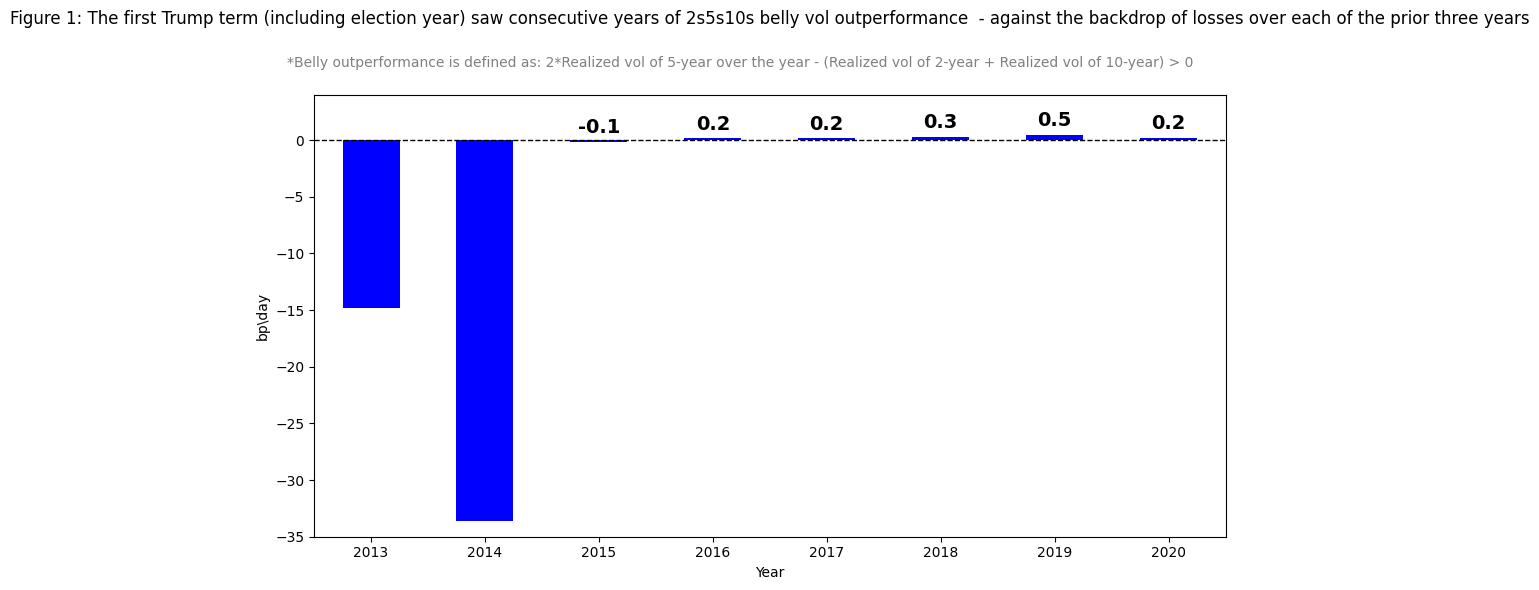

In [6]:



df_total_2['2yr_swap_pct_returns'] = df_total_2['2yr_OIS_swap'].pct_change()
df_total_2['5yr_swap_pct_returns'] = df_total_2['5yr_OIS_swap'].pct_change()
df_total_2['10yr_swap_pct_returns'] = df_total_2['10yr_OIS_swap'].pct_change()


# Calculate the 'quantity' based on the formula using the 30-day volatility of 2yr, 5yr, and 10yr yields
df_total_2['2yr_swap_vol'] = df_total_2['2yr_swap_pct_returns'].rolling(window=252).std() 
df_total_2['5yr_swap_vol'] = df_total_2['5yr_swap_pct_returns'].rolling(window=252).std() 
df_total_2['10yr_swap_vol'] = df_total_2['10yr_swap_pct_returns'].rolling(window=252).std() 

df_total_2['quantity'] = (2*df_total_2['5yr_swap_vol'] - (df_total_2['2yr_swap_vol'] + df_total_2['10yr_swap_vol'])) * 100


# Extract the year from the 'Date' column for grouping
df_total_2['Year'] = df_total_2['Date'].dt.year

# Group by the 'Year' and calculate the last value of 'quantity' for each year
annual_quantity = df_total_2.groupby('Year')['quantity'].last()

# Filter for specific years
annual_quantity = annual_quantity[annual_quantity.index.isin([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])]  # Filter for years 2014-2019

# Plotting
plt.figure(figsize=(10, 6))
ax = annual_quantity.plot(kind='bar', color='blue')

plt.title('Figure 1: The first Trump term (including election year) saw consecutive years of 2s5s10s belly vol outperformance  - against the backdrop of losses over each of the prior three years\n\n\n')
plt.xlabel('Year')
plt.ylabel('bp\day')

plt.figtext(0.5, 0.88, '*Belly outperformance is defined as: 2*Realized vol of 5-year over the year - (Realized vol of 2-year + Realized vol of 10-year) > 0', ha='center', fontsize=10, color='gray')
plt.ylim(-35, 4)
plt.xticks(rotation=0)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Add value annotations above each bar
for i, v in enumerate(annual_quantity):
    if v<-1:
        continue
    ax.text(i, v + 1.5*(annual_quantity.max()), f"{v:.1f}", ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{figure_path}/figure1.jpg', format='jpeg', bbox_inches='tight')
plt.show()




FIGURE 2

0      2006-12-06
1      2006-12-07
2      2006-12-08
3      2006-12-11
4      2006-12-12
          ...    
4432   2024-11-21
4433   2024-11-22
4434   2024-11-25
4435   2024-11-26
4436   2024-11-27
Name: Date, Length: 4437, dtype: datetime64[ns]


<>:60: SyntaxWarning: invalid escape sequence '\d'
<>:60: SyntaxWarning: invalid escape sequence '\d'
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_65744/1624463082.py:60: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('bp\day', fontsize=12)
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_65744/1624463082.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_quantity_filtered.index, y=avg_quantity_filtered.values, palette=['blue', 'blue', 'blue'])


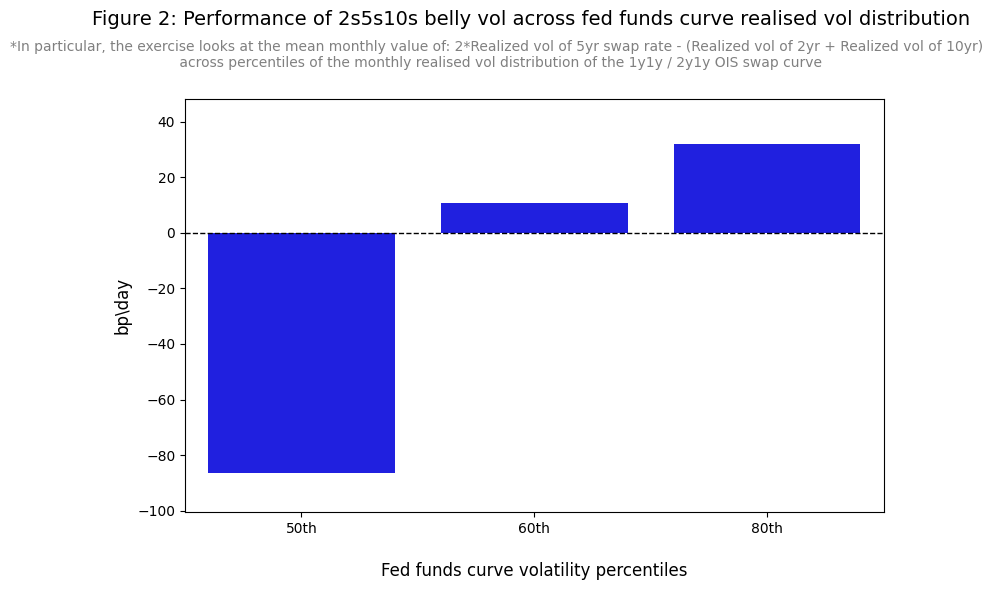

In [7]:

print(df_total_2.Date)
df_total_2['2yr_swap_pct_returns'] = df_total_2['2yr_OIS_swap'].pct_change()
df_total_2['5yr_swap_pct_returns'] = df_total_2['5yr_OIS_swap'].pct_change()
df_total_2['10yr_swap_pct_returns'] = df_total_2['10yr_OIS_swap'].pct_change()

# Calculate curve as difference between 4y1y and 1y1y
df_total_2['curve'] = df_total_2['2y1y'] - df_total_2['1y1y']

# Calculate the rolling 30-day realized volatility of the 'curve' variable
df_total_2['curve_pct_change'] = df_total_2['curve'].pct_change()

# Calculate the 30-day rolling standard deviation (realized volatility) 
df_total_2['curve_vol_30d'] = df_total_2['curve_pct_change'].rolling(window=30).std() 

# Calculate the 'quantity' based on the formula using the 30-day volatility of 2yr, 5yr, and 10yr yields
df_total_2['2yr_swap_vol_30d'] = df_total_2['2yr_swap_pct_returns'].rolling(window=30).std() 
df_total_2['5yr_swap_vol_30d'] = df_total_2['5yr_swap_pct_returns'].rolling(window=30).std() 
df_total_2['10yr_swap_vol_30d'] = df_total_2['10yr_swap_pct_returns'].rolling(window=30).std() 

df_total_2['quantity_30d'] = (2*df_total_2['5yr_swap_vol_30d'] - (df_total_2['2yr_swap_vol_30d'] + df_total_2['10yr_swap_vol_30d'])) * 100

# Compute percentiles for different categories
vol_50 = df_total_2['curve_vol_30d'].quantile(0.50)
vol_80 = df_total_2['curve_vol_30d'].quantile(0.80)
vol_60 = df_total_2['curve_vol_30d'].quantile(0.60)

# Categorize into Bottom 20%, Middle 50%, and Top 30%
def categorize_vol(value):
    if value < vol_50:
        return '50th'  # Below the 20th percentile
    elif value > vol_80:
        return '80th'  # Above the 80th percentile
    elif value > vol_60:
        return '60th'  # Between the 70th and 80th percentiles
    else:
        return 'Middle 50%'  # Between the 20th and 70th percentiles

df_total_2['vol_category'] = df_total_2['curve_vol_30d'].apply(categorize_vol)

# Compute average of 'quantity_30d' for each category
avg_quantity = df_total_2.groupby('vol_category')['quantity_30d'].mean()


# Filter only 'Bottom 20%', 'Middle 50%', and 'Top 30%' categories
avg_quantity_filtered = avg_quantity[['50th', '60th', '80th']]

# Set custom y-axis range (Modify as needed)
y_min = avg_quantity_filtered.min() - 14  # Adjust margin below min
y_max = avg_quantity_filtered.max() + 16  # Adjust margin above max

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_quantity_filtered.index, y=avg_quantity_filtered.values, palette=['blue', 'blue', 'blue'])

# Add labels and title
plt.title('Figure 2: Performance of 2s5s10s belly vol across fed funds curve realised vol distribution \n\n\n', fontsize=14)
plt.figtext(0.5, 0.88, ' \n*In particular, the exercise looks at the mean monthly value of: 2*Realized vol of 5yr swap rate - (Realized vol of 2yr + Realized vol of 10yr) \n across percentiles of the monthly realised vol distribution of the 1y1y / 2y1y OIS swap curve', ha='center', fontsize=10, color='gray')

plt.xlabel('\nFed funds curve volatility percentiles', fontsize=12)
plt.ylabel('bp\day', fontsize=12)
plt.xticks(rotation=0)

# Add horizontal dotted line at zero
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set custom y-axis limits
plt.ylim(y_min, y_max)

# Save and show plot
plt.tight_layout()
plt.savefig(f'{figure_path}/figure2.jpg', format='jpeg', bbox_inches='tight')
plt.show()



